# Milestone 2: Regression Model

**Authors**: __Khizer Zakir & Rodrigo Brust Santos__

__October 2023__

_____

In [ ]:
#!pip install folium, esda, libpysal -q

In [75]:
#basic libraries
import pandas as pd
import numpy as np

#graphic and charts
import matplotlib.pyplot as plt
import seaborn as sns 

#machine learning
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.metrics import mean_absolute_error, mean_squared_error, make_scorer
from sklearn.model_selection import GroupKFold, cross_val_score, cross_val_predict
from sklearn.metrics import r2_score

#spatial libraries
import geopandas as gpd
import folium 

# For spatial statistics
import esda
from esda.moran import Moran, Moran_Local

import splot
from splot.esda import moran_scatterplot, plot_moran, lisa_cluster,plot_moran_simulation
import libpysal as lps

%matplotlib inline

## Table Of Contents


____

## 0. Improving Section from #Milestone1

#### Required Improvements


`a)` explain why a random train-test split procedure that does not take into account spatial correlations is good enough for the targeted application

`b)` explain the role of location data and if they will be used in future experiments

- Location data is important to identify the samples. It is fundamental for understanding the spatial autocorrelation among the samples, however, not so important when buiding the Logistic Regression, for example. Due to that, the coordinates X and Y were not normalized like other variables, since they will not be used in the explanable variables.

Below, we will conduct an spatial autocorrelation test to check whether our thoughts are correct or not. Then proceed to a proper train-test-split.



In [20]:
# read the basin file
gdf = gpd.read_file('../dataset/basins/basins.json')


In [21]:
#loading samples files
file_path = '../dataset/stream_samples_cleaned.csv'
df = pd.read_csv(file_path)

#transforming to geo data frame
data_points = gpd.GeoDataFrame(df, crs= '31983' ,geometry=gpd.points_from_xy(df.x, df.y))
data_points.head(2)


,x,y,Ag (ppm),Al (%),As (ppm),Ba (ppm),Be (ppm),Bi (ppm),Ca (%),Cd (ppm),...,Sr (ppm),Th (ppm),Ti (%),U (ppm),V (ppm),W (ppm),Y (ppm),Zn (ppm),Zr (ppm),geometry
0,248757,7972050,0.03,2.63,4.0,76.0,1.0,0.31,0.05,0.03,...,3.3,7.4,0.03,0.70,73,0.3,13.15,27,6.3,POINT (248757.000 7972050.000)
1,244460,7973135,0.02,1.93,2.0,84.0,1.7,0.29,0.04,0.01,...,3.1,8.2,0.06,0.94,58,0.3,23.90,58,6.9,POINT (244460.000 7973135.000)


In [22]:
#converting to the same 
gdf = gdf.to_crs(epsg = 4326)
data_points = data_points.to_crs(epsg = 4326)

# check the crs
gdf.crs, data_points.crs

(<Geographic 2D CRS: EPSG:4326>
 Name: WGS 84
 Axis Info [ellipsoidal]:
 - Lat[north]: Geodetic latitude (degree)
 - Lon[east]: Geodetic longitude (degree)
 Area of Use:
 - name: World.
 - bounds: (-180.0, -90.0, 180.0, 90.0)
 Datum: World Geodetic System 1984 ensemble
 - Ellipsoid: WGS 84
 - Prime Meridian: Greenwich,
 <Geographic 2D CRS: EPSG:4326>
 Name: WGS 84
 Axis Info [ellipsoidal]:
 - Lat[north]: Geodetic latitude (degree)
 - Lon[east]: Geodetic longitude (degree)
 Area of Use:
 - name: World.
 - bounds: (-180.0, -90.0, 180.0, 90.0)
 Datum: World Geodetic System 1984 ensemble
 - Ellipsoid: WGS 84
 - Prime Meridian: Greenwich)

<Axes: >

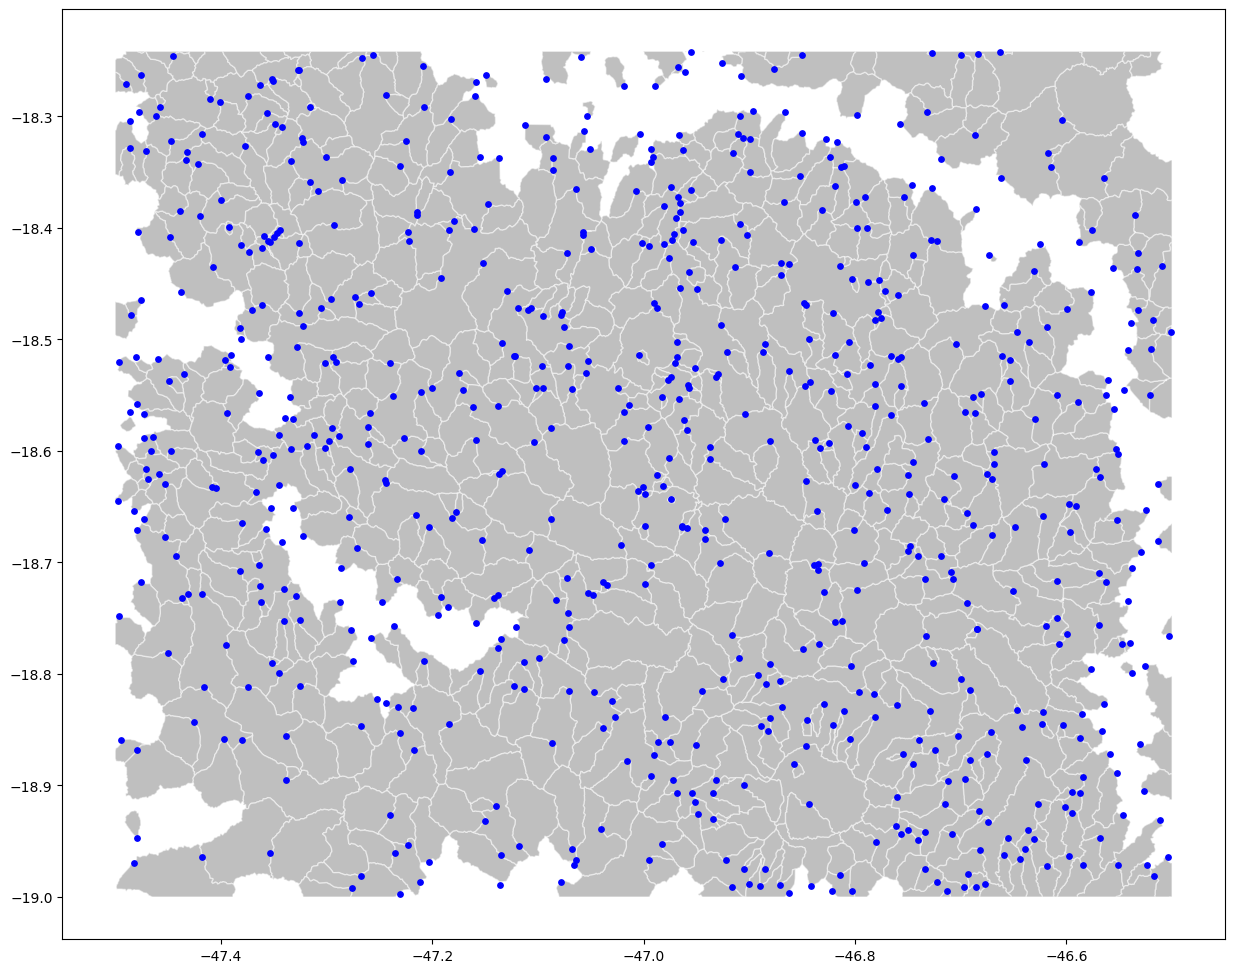

In [23]:
fig, ax = plt.subplots(1,1,figsize=(15, 15))

# basins
gdf.plot(ax=ax, 
        color='gray', 
        edgecolor='white',
        alpha=0.5)

# samples
data_points.plot(ax=ax, 
            color='blue',
            markersize=15)


#### Interpretation

A general observation here: the all the data points are well dispered along the AOI, except for a few points that are clustered along the same basin. To address this spatial autocorrelation in our data points we are implementing Moran's I to identify the spatial autocorrelation and take it into account while splitting the dataset. 

In the following blocks of code, we will normzalize the data with respect to the count of data points within each data basin. We used the min-max scaling technique to normalize the data for this particular task. 
___

In [25]:
#spatial join between points and basins, keeping only points geometry
gdf_new = gpd.sjoin(data_points, gdf, how='left', predicate='within')
gdf_new.head()

,x,y,Ag (ppm),Al (%),As (ppm),Ba (ppm),Be (ppm),Bi (ppm),Ca (%),Cd (ppm),...,Ti (%),U (ppm),V (ppm),W (ppm),Y (ppm),Zn (ppm),Zr (ppm),geometry,index_right,OBJECTID
0,248757,7972050,0.03,2.63,4.0,76.0,1.0,0.31,0.05,0.03,...,0.03,0.70,73,0.3,13.15,27,6.3,POINT (-47.37716 -18.32652),1.0,2.0
1,244460,7973135,0.02,1.93,2.0,84.0,1.7,0.29,0.04,0.01,...,0.06,0.94,58,0.3,23.90,58,6.9,POINT (-47.41765 -18.31621),2.0,3.0
2,244044,7970217,0.04,1.47,3.0,70.0,0.7,0.19,0.11,0.06,...,0.04,0.65,55,0.2,10.40,34,1.8,POINT (-47.42195 -18.34251),5.0,6.0
3,242895,7970593,0.05,1.72,23.0,80.0,1.1,0.32,0.04,0.08,...,0.04,1.01,66,0.7,9.34,27,4.1,POINT (-47.43277 -18.33897),5.0,6.0
4,242999,7971416,0.04,0.97,7.0,56.0,0.5,0.22,0.03,0.05,...,0.05,0.82,41,0.4,7.45,28,1.5,POINT (-47.43168 -18.33155),5.0,6.0


In [27]:
data_points_by_basin = gdf_new['OBJECTID'].value_counts().rename_axis('OBJECTID').reset_index(name='counts')
data_points_by_basin.head(10)

,OBJECTID,counts
0,405.0,9
1,507.0,8
2,3425.0,7
3,726.0,6
4,261.0,5
5,1078.0,5
6,194.0,5
7,233.0,5
8,165.0,4
9,987.0,4


In [29]:
gdf_update = gdf_new.merge(data_points_by_basin, on='OBJECTID')

# Min-Max Scaling

min_count = gdf_update['counts'].min()
max_count = gdf_update['counts'].max()

gdf_update['scaled_counts'] = (gdf_update['counts'] - min_count) / (max_count - min_count)

# Display the first few rows
gdf_update.head()


        x        y  Ag (ppm)  Al (%)  As (ppm)  Ba (ppm)  Be (ppm)  Bi (ppm)  \
0  248757  7972050      0.03    2.63       4.0      76.0       1.0      0.31   
1  244460  7973135      0.02    1.93       2.0      84.0       1.7      0.29   
2  244044  7970217      0.04    1.47       3.0      70.0       0.7      0.19   
3  242895  7970593      0.05    1.72      23.0      80.0       1.1      0.32   
4  242999  7971416      0.04    0.97       7.0      56.0       0.5      0.22   

   Ca (%)  Cd (ppm)  ...  V (ppm)  W (ppm)  Y (ppm)  Zn (ppm)  Zr (ppm)  \
0    0.05      0.03  ...       73      0.3    13.15        27       6.3   
1    0.04      0.01  ...       58      0.3    23.90        58       6.9   
2    0.11      0.06  ...       55      0.2    10.40        34       1.8   
3    0.04      0.08  ...       66      0.7     9.34        27       4.1   
4    0.03      0.05  ...       41      0.4     7.45        28       1.5   

                      geometry  index_right  OBJECTID  counts  scale

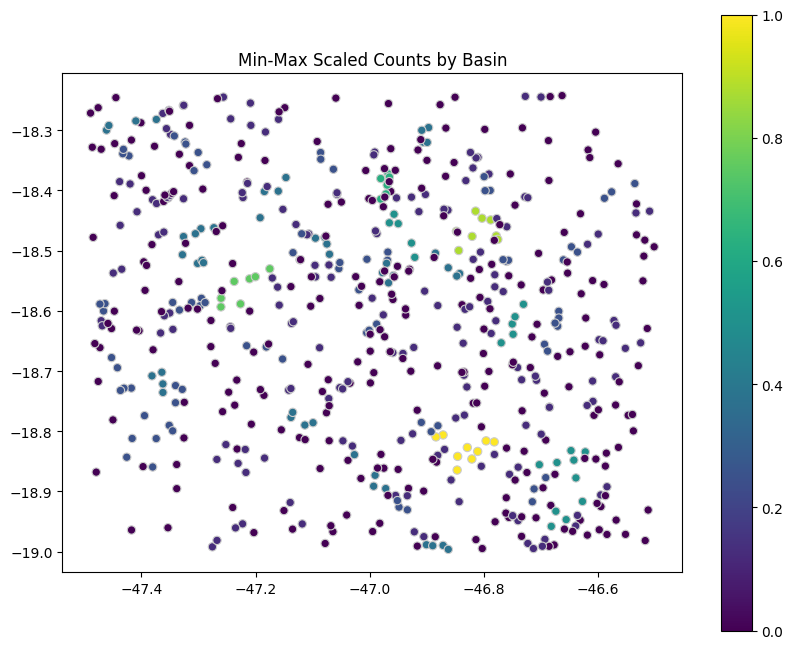

In [30]:
fig, ax = plt.subplots(figsize=(10, 8))

# Plot the choropleth map with normalized values
gdf_update.plot(column='scaled_counts', cmap='viridis', linewidth=0.8, ax=ax, edgecolor='0.8', legend=True)

# Set the title
ax.set_title('Min-Max Scaled Counts by Basin')

# Show the plot
plt.show()


#### Moran's I

As per the spatial autocorrelation documentation for ArcGIS Pro, Moran's I is a tool to measure spatial autocorrelation based on both feature locations and feature values simultaneously [How Spatial Autocorrelation (Global Moran's I) works](https://pro.arcgis.com/en/pro-app/latest/tool-reference/spatial-statistics/h-how-spatial-autocorrelation-moran-s-i-spatial-st.htm) - Esri

To run the moran's I and understand the spatial autocorrelation, we would first need to define spatial weights. It determines how we define the neighborhood. Question is how do we define the neighborhood for these basins? Do we apply rook method, queen's method or other contiguous matrix method or something else. Given the effectiveness of the aforementioned methods on rather regular geometries, we have considered K-nearest neighbor method to define spatial weights. It considers the defined number of neighbors and assign weights based on proximity, as it follows inverse distance $1/distance$ approach, closer neighbors get more weights. For this task, we are using the [libpysal](https://pysal.org/notebooks/lib/libpysal/weights.html). There is only one essential paraemeter = number of neighbors to be defined and the algorithm calculates spatial weights using the euclidean distance by default. Further options can be explored using the link to the documentation.

Note: we considered k = 8 by personal choice for no particular reason. 

Once the spatial weights are in line, we tranform them using the row standardization method. According to the documentation on spatial weights on the esri website "row standardization is used to create proportional weights in cases where features have an unequal number of neighbors. Row standardization involves dividing each neighbor weight for a feature by the sum of all neighbor weights for that feature and is recommended whenever the distribution of your features is potentially biased due to sampling design or an imposed aggregation scheme. You will almost always want to apply row standardization when your features are polygons." [(Spatial Weights)](https://desktop.arcgis.com/en/arcmap/latest/tools/spatial-statistics-toolbox/spatial-weights.htm#:~:text=Row%20standardization%20involves%20dividing%20each,or%20an%20imposed%20aggregation%20scheme) - ESRI


In [31]:
# calculate spatial weight

wq =  lps.weights.KNN.from_dataframe(gdf_update,k=8)

# Row-standardization

wq.transform = 'r'

wq.neighbors[1]

[4, 2, 3, 5, 9, 8, 0, 12]

#### Spatial Lag
Spatial lags give the information about the k-neighbors (surronding). Example, the normalized value tells how many datapoints are in the basin and then the spatial lag tells how many data points are in the assigned number of neighbors. 
spatial lag helps us understand the spatial patterns and relationships in a dataset by looking at how the values of a variable in a given location are related to the values in its neighboring locations.

In [32]:
gdf_update['scaled_lag'] = lps.weights.lag_spatial(wq, gdf_update['scaled_counts'])

gdf_update.sample(10)[['OBJECTID','counts','scaled_counts','scaled_lag']]

,OBJECTID,counts,scaled_counts,scaled_lag
380,405.0,9,1.000,0.390625
304,3425.0,7,0.750,0.406250
524,593.0,2,0.125,0.078125
570,976.0,1,0.000,0.250000
250,3349.0,1,0.000,0.125000
500,562.0,1,0.000,0.156250
402,60.0,2,0.125,0.046875
293,3381.0,2,0.125,0.140625
33,359.0,2,0.125,0.078125
329,3420.0,3,0.250,0.218750


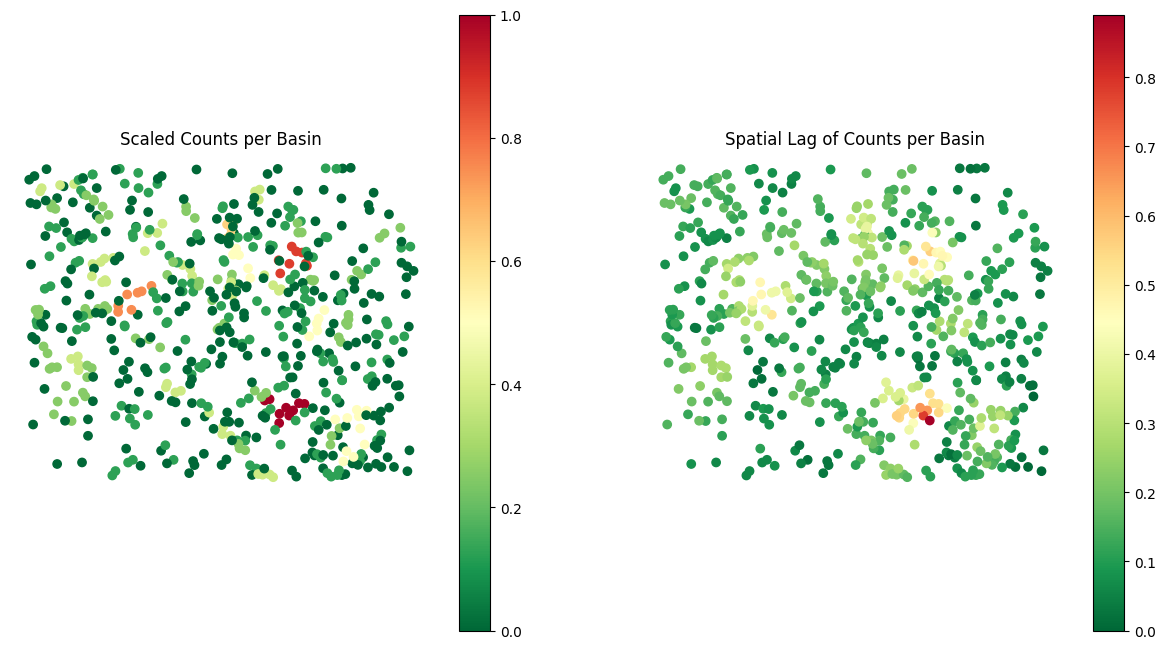

In [33]:
# create the 1x2 subplots
fig, ax = plt.subplots(1, 2, figsize=(15, 8))

# regular count map 
gdf_update.plot(ax=ax[0], 
         column='scaled_counts', 
         cmap='RdYlGn_r', 
         legend=True
           )


ax[0].axis("off")
ax[0].set_title("Scaled Counts per Basin")

# spatial lag map 
gdf_update.plot(ax=ax[1], 
         column='scaled_lag', 
         cmap='RdYlGn_r',
         legend=True
           )

ax[1].axis("off")
ax[1].set_title("Spatial Lag of Counts per Basin")


plt.show()

#### Global Moran's I

This following brief section with **Moran** function helps us identify the global moran's I for our dataset. The output of this function or the Global Moran's I value ranges from -1 to 1 and can be interpreted as following:
- A positive value indicates positive spatial autocorrelation (similar values are close to each other).
- A negative value indicates negative spatial autocorrelation (dissimilar values are close to each other).
- A value near 0 suggests no significant spatial autocorrelation.

You may notice that we have estimated the p-value for our moran value as well that signifies that the distribution of our datapoints is not random. Generally, the null hypothesis = the distribution is random, but it the p-value is significant we reject the null hypothesis and assume that the distribution is either dispersed (-ive value) or clustered (+ive value). 

In [36]:
y = gdf_update['scaled_counts']
moran = Moran(y, wq)
round(moran.I,2)

0.28

In [44]:
#fig, ax = moran_scatterplot(moran, aspect_equal=True)
#plt.show()

In [45]:
#plot_moran_simulation(moran,aspect_equal=False, legend = True)

# The plot simulation of the moran's I helps us compare the value of randomness vs non-randomness of our data. We can also check the p-value 

In [41]:
# p_value
moran.p_sim

0.001

#### Interpretation

Moran's I value = **0.28** and the p-value is statistically significant that means that our distribution is clustered and not random. 


#### Local Spatial Autocorrelation (LISA)

LISA produces results for each spatial unit, in our case datapoint(s) from one basin to the other. 

The results are generally group as HH, LL, HL, LH. L = low and H = high. 
- HH - high values surronded by high values
- LL - low values surronded by low values
- HL - high values surrounded by low values
- LH - low values surrounded by high values 
- ns - not significant

These values help us understand the pattern of clustering in our dataset.

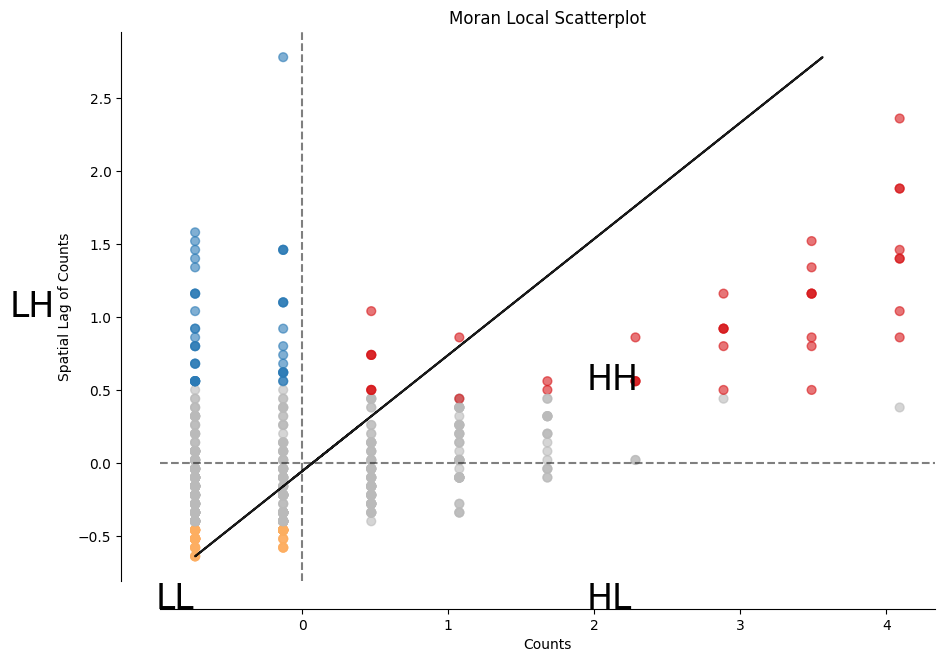

In [42]:
# calculate local moran values
lisa = esda.moran.Moran_Local(y, wq)

# Plot
fig,ax = plt.subplots(figsize=(10,15))

moran_scatterplot(lisa, ax=ax, p=0.05)
ax.set_xlabel("Counts")
ax.set_ylabel('Spatial Lag of Counts')

# add some labels
plt.text(1.95, 0.5, "HH", fontsize=25)
plt.text(1.95, -1, "HL", fontsize=25)
plt.text(-2, 1, "LH", fontsize=25)
plt.text(-1, -1, "LL", fontsize=25)
plt.show()

#### Spatial Autocorrelation Map

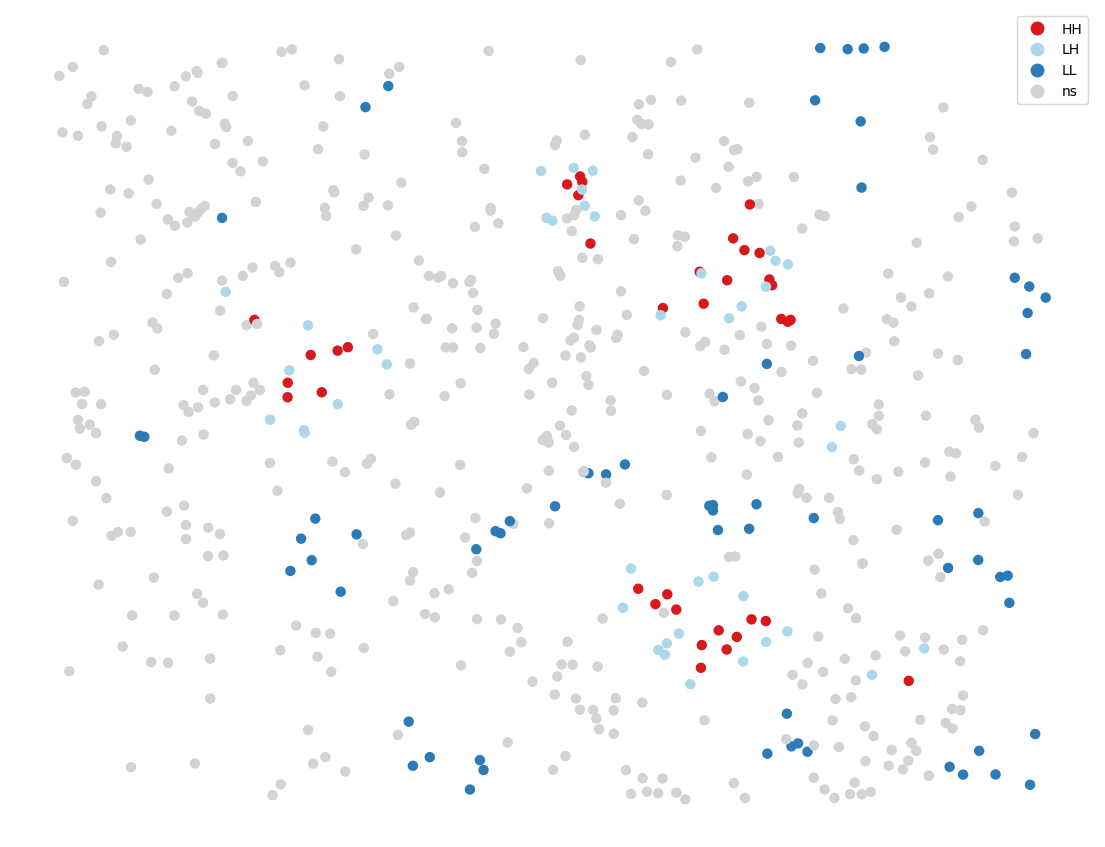

In [43]:
fig, ax = plt.subplots(figsize=(14,12))
lisa_cluster(lisa, gdf_update, p=0.05, ax=ax)
plt.show()

**Conclusion on Spatial Autocorrelation**

- Our samples have spatial autocorrelation. This means it is necessary to peform another train-test-split, taking into consideration the basins. 

- Since we have the global Moran's I equals **0.28**, meaning that our samples are moderately correlated, we expect that it brings some impact to our model.
____

`c)` further explain the role of cross-validation for future experiments

- Cross Validation will be used in order to improve our model accuracy, avoiding overfitting. Especially when it is taken into consideration that samples that are closer have chemical correlation because of the same rock source origin. 

- Since we have this spatial correlation, it will be necessary to split the data according to the watershed source of the samples. For that, it is not possible to utilise the regular `cross validation` function. For that, we will try to implement cross validation functions that allow us to separate these fuctions according to the watershed index. Scikit Learn provides functions to perform cross validation among groups. In this project, `GroupKFold()` will be used.

- In Linear Regression, we are using CV for improving the model accuracy. For other models, especially those that need to set hyperparameters, we will use CV to tune them. 

- With Cross Validation we will be able to set the hyperparameters and then find the optimal values, using several batches of test samples, avoiding the spatial correlation of the dataset.


`d)` Structure the notebook and hierarchize the different analysis and experiments

`e)` Submit only one notebook for each of the next milestones

- for this two sections, we reestructured the whole notebook, creating a more organized content. For better navigating, a table of contents was created, allowing the user to click on the topic and navigate stright to the desired topic. 

- Also, to avoid verbose cells that would take a lot of space, we created a `milestone_function.py` where we put all our functions to better organize it.

- Several detailed comments from the feedback were taken into consideration, and we explained better some approaches taken in the last notebook, either showing references or explaining why it was an arbitraty decision.

- We removed the execessive amount of plots, besides adding the spatial distribution of train and test samples.



_____

## 1.Regression Algorthm Selection 




#### 1.1 Improving Train-Test-Split

Taking in consideration the just shown Spatial Autocorrelation, where the Moran's I indicated moderated spatial autocorrelation, it is necessary to perform a better train-test-split. This update in the data separation is a way of avoiding data leakage, where correlated samples are in the test and train data - making the prediction having an almost perfect fit, what does not really represent the reality. 

In this update, we will separate the samples according to the basin ID, this is based on the assumption that some of our datapoints are spatially autocorrelation. We can refer back to the Local Moran's I map, where we see small clusters of HH and LL values.

To address this phenomenon, we are going to adopt the `GroupKFold()` Splitter Classes function provided by Scikit-learn. This choice has been made after reviewing several sources who have adopted similar strategy to address the similar challenges to avoid data leakage and guarantee a good data split while dataset is spatially autocorrelated. 


In [47]:
#loading data frame
df = pd.read_csv('../dataset/stream_samples_basin_id.csv')

#removing columns that wont be used
df.drop(columns = ['geometry', 'index_right'], inplace = True)

df.rename(columns = {'OBJECTID':'basin_id'}, inplace = True)

df.head(2)

,x,y,Ag (ppm),Al (%),As (ppm),Ba (ppm),Be (ppm),Bi (ppm),Ca (%),Cd (ppm),...,Sr (ppm),Th (ppm),Ti (%),U (ppm),V (ppm),W (ppm),Y (ppm),Zn (ppm),Zr (ppm),basin_id
0,248757,7972050,0.03,2.63,4.0,76.0,1.0,0.31,0.05,0.03,...,3.3,7.4,0.03,0.70,73,0.3,13.15,27,6.3,2
1,244460,7973135,0.02,1.93,2.0,84.0,1.7,0.29,0.04,0.01,...,3.1,8.2,0.06,0.94,58,0.3,23.90,58,6.9,3


In [48]:
#variable that we will predict
Y_column = 'Zn (ppm)'

#explanatory variables
X_columns = list(df.iloc[:, :-1])

#dropping Zn from our explanatory variables
X_columns.remove('Zn (ppm)')

In [50]:
#generating the X and Y dataset and transforming to numpy array
X, Y = df[X_columns].to_numpy(), df[Y_column].to_numpy()

#defining the watershed number as the group
groups = df['basin_id'].to_numpy()


The `GroupKFold()` requires the parameter `n_splits` to be defined. The methodology adopted for performing this [Chiara, 2021](https://towardsdatascience.com/spatial-cross-validation-using-scikit-learn-74cb8ffe0ab9)

- Arbitrarily using `n_splits`=**4**.

In [51]:
# test_size = 0.3 #setting the test size. 
n_splits = 4   #setting the number of splits, arbitrarly.

group_kfold = GroupKFold(n_splits=n_splits)

basin_kfold = group_kfold.split(X, Y, groups)

# Create a nested list of train and test indices for each fold
train_indices, test_indices = [list(traintest) for traintest in zip(*basin_kfold)]

basin_cv = [*zip(train_indices,test_indices)]

#### 1.2 Regression Model 

The selected regression model is a multiple linear regression. This selection is based on our dataset, since there are multiple variables and we are trying to explain only one, which is the zinc concentration.

##### Thought-process:
The following model fitting, regularization, and model evaluation is based on the assumption that `GroupKFold()` automatically takes care of splitting your data into training and testing sets according to the specified GroupKFold cross-validation strategy.


In [81]:
# model
linear_clf = LinearRegression().fit(X, Y)

# fit and predict at the same time consdering the cv = basin_cv takes care of the data splitting

y_pred = cross_val_predict(linear_clf, X, Y, cv=basin_cv, groups=groups)

scores = cross_val_score(linear_clf, X, Y, cv=basin_cv, groups=groups)

# mean of scores
score_mean = round(scores.mean() * 100, 2)

# Print the cross-validated score
print(f'GroupKFold Cross Validation Score: {score_mean}%')

# Calculate evaluation metrics
rmse = mean_squared_error(Y, y_pred, squared=False)
mse = mean_squared_error(Y, y_pred)
r2 = r2_score(Y, y_pred)

GroupKFold Cross Validation Score: 56.07%


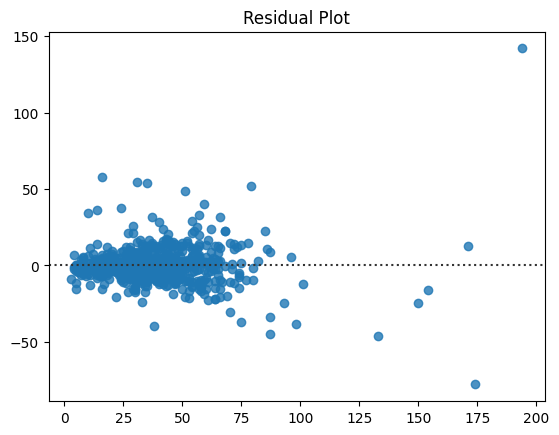

In [71]:
#residual plot
sns.residplot(x = Y, y = y_pred)
plt.title('Residual Plot');

##### Residual Plot

An important thing to notice in this residual plot is that the residuals are evenly distributed along the y = 0 line, which indicates that the multiple linear regression model is good for the data. If there were different patterns observed in the residuals we might have had to consider fitting other model. Meanwhile, to improve the residual plot and the performance of the model in general, we need to tune our parameters and hyperparameters.

In [73]:
mreg_coeff = pd.DataFrame()

mreg_coeff['columns'] = X_columns
mreg_coeff['Coefficient Estimate'] = pd.Series(linear_clf.coef_)

mreg_coeff

,columns,Coefficient Estimate
0,x,0.000045
1,y,0.000043
2,Ag (ppm),-1.638405
3,Al (%),0.628614
4,As (ppm),0.149464
5,Ba (ppm),0.015147
6,Be (ppm),-2.185190
7,Bi (ppm),3.189370
8,Ca (%),-0.908441
9,Cd (ppm),12.298184


## 3. Regularization & Model Sensitivity 


It has been discussed in the class and we have read in on numerous occasions that when your model underfits or overfits, we introduce regularization to bring a balance back to our model with imposing heavy penalities on the model. The general idea of regularization is not complicated to understand, while it is complicated to choose the right form of it and implement it. To do that you must understand your data well and must understand the performance of your model as well to observe even the slight bit of changes it may bring. It is not obligatory that the regularization of your model will always improve accuracy of your model but the changes may be observed simply in the coefficient values of the explanatory variables ([Simplilearn, 2023](https://www.simplilearn.com/tutorials/machine-learning-tutorial/regularization-in-machine-learning#:~:text=Regularization%20refers%20to%20techniques%20that,and%20prevent%20overfitting%20or%20underfitting.&text=Using%20Regularization%2C%20we%20can%20fit,reduce%20the%20errors%20in%20it)). 

In general there are two major types of regularization, Lasso and ridge. The former penalizes the model with the sum of absolute coefficient values, which increases the error. On the other hand, the latter adds the sum of squares of the coefficients to penalize the model. Former may tune down some coefficients to exactly 0 to sparse the model, while the ridge model is better as it does not completely nullify any of the explanatory variables. 

In our example, after reviewing few examples, we are focusing on the ridge regularization, as it has been suggested to account colinearity better. Because it distributes weight among the correlated variables.

**hyperparameter term  `lambda * ||w||^2_2`** according to [Sklearn documentation](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Ridge.html)


In [56]:
scorer = make_scorer(mean_squared_error)
scorer

make_scorer(mean_squared_error)

187.06627429868468
187.0547204722928
186.46833452580023
186.9418083080424
185.90112476121567
182.38242870257886
179.9894465654952
176.94360791999117
177.5259122936877
178.94054301753337


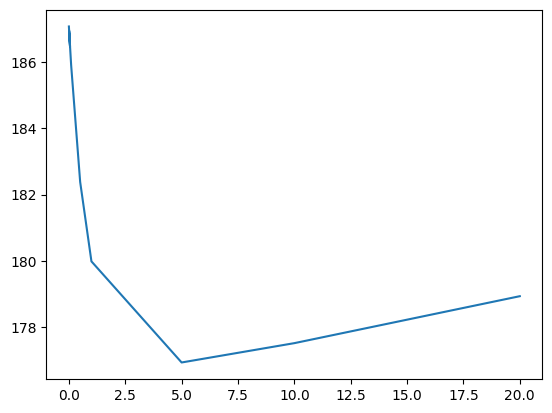

In [59]:
# Create a Ridge regression object
ridge = Ridge()

mean_cv_list = []
mse_list = []
alpha = [1e-4, 0.001, 0.05, 0.01, 0.1, 0.5, 1, 5, 10, 20]
for i in alpha:
    elastmodel = Ridge(alpha=i).fit(X, Y)
    cv = cross_val_score(elastmodel, X, Y, cv=basin_cv, scoring=scorer)
    mean_cv = np.mean(cv)
    print(mean_cv)
    
    mean_cv_list.append(mean_cv)


plt.plot(alpha, mean_cv_list)

#### Interpretation

The plot describes the deveiation of `MSE` with respect to the **lambda** hyperparameter. The value of `MSE` is very high with low lambda values, but it starts to drop for values around 5. And, the curve start to again, once the model goes beyond the apparent range of optimal lambda values. 

176.942503727147


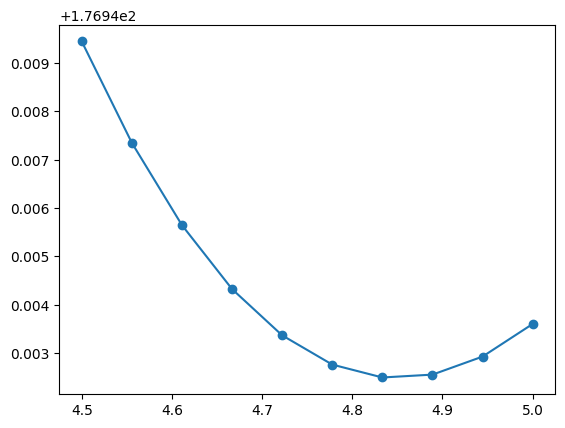

In [60]:
lam = np.linspace(4.5, 5, 10)

# Create a Ridge regression object
ridge = Ridge()

mean_cv_list = []
mse_list = []
alpha = lam
for i in alpha:
    elastmodel = Ridge(alpha=i).fit(X, Y)
    y_pred = cross_val_predict(elastmodel, X, Y, cv = basin_cv)
    cv = cross_val_score(elastmodel, X, Y, cv=basin_cv, scoring=scorer)
    mean_cv = np.mean(cv)
    mse = mean_squared_error(Y, y_pred )
    mean_cv_list.append(mean_cv)


dic = dict(zip(mean_cv_list, alpha))
print(dic[np.min(mean_cv_list)])

plt.scatter(alpha, mean_cv_list)

#### Interpretation

This magnified view of this plot helps us identify the optimal lambda value where your MSE is the lowest. The value w.r.t to the previous code block = 4.833. 


#### Model with the Optimal Lambda Hyperparameter

In [84]:
#using the optimal learning rate

elastmodel = Ridge(alpha=4.83).fit(X, Y)

y_pred = cross_val_predict(elastmodel, X, Y, cv = basin_cv)

cv = cross_val_score(elastmodel, X, Y, cv=basin_cv)
print(cv)
mean_cv = np.mean(cv)
print(f'Mean CV-Score {mean_cv:.2}')
    
# Calculate evaluation metrics
rmse_ridge = mean_squared_error(Y, y_pred, squared=False)
mse_ridge = mean_squared_error(Y, y_pred)
r2_ridge = r2_score(Y, y_pred)


[0.5959173  0.64619407 0.52781424 0.5441616 ]
Mean CV-Score 0.58


In [86]:
#checking the coefficients
elastmodel_coeff = pd.DataFrame()

elastmodel_coeff['columns'] = X_columns
elastmodel_coeff['Coefficient Estimate'] = pd.Series(elastmodel.coef_)

#adding MLR Coefficient to the same table
elastmodel_coeff['MLR_Coef_Est'] =mreg_coeff['Coefficient Estimate']

#checking their difference
elastmodel_coeff['Difference'] = elastmodel_coeff['Coefficient Estimate'] - elastmodel_coeff['MLR_Coef_Est']

elastmodel_coeff.sort_values('MLR_Coef_Est', ascending = False)

,columns,Coefficient Estimate,MLR_Coef_Est,Difference
18,Hg (ppm),1.892976,44.623090,-42.730114
20,K (%),8.882716,39.430435,-30.547719
24,Mg (%),11.313722,27.545539,-16.231817
37,Ti (%),3.126646,15.164919,-12.038273
9,Cd (ppm),5.403615,12.298184,-6.894569
32,Sb (ppm),8.415879,10.782258,-2.366378
7,Bi (ppm),3.403544,3.189370,0.214175
34,Sn (ppm),1.640322,2.090598,-0.450275
22,Li (ppm),1.276423,1.011489,0.264934
3,Al (%),1.468664,0.628614,0.840050


##### Interpretation

The tables above show the coefficient distribution of ridge regression model and the multiple inital linear regression model for our dataset. 

Despite the score from `cross_val_predict()` function present only a 2% shy improvement, it was possible to see that the ridge regularizer has distributed the weights among the correlated variables. This indicates that both the models have identified same explanatory varibles to be most important; however, for the ridge regressor the values are more distributed and small compare to the initial model. 

## 4. Model Evaluation



In [83]:
# Print evaluation metrics
print('Multiple Linear Regression Metrics')
print(f'MSE: {mse:.3f} \nRMSE: {rmse:.3f} \nR2: {r2:.3f}')
print('---------------------------')
print('Ridge Regression Metrics')
print(f'MSE: {mse_ridge:.3f} \nRMSE: {rmse_ridge:.3f} \nR2: {r2_ridge:.3f}')

Multiple Linear Regression Metrics
MSE: 187.134 
RMSE: 13.680 
R2: 0.570
---------------------------
Ridge Regression Metrics
MSE: 176.977 
RMSE: 13.303 
R2: 0.594


##### Interpretation

The Multiple Linear Regression (`MLR`) showed a fit of 57% of the model to the dataset. The Model's  Root Mean Square Error (`RSME`) presents a 13.3 zinc concentration in ppm. This means that a value of 15 was acctually predicted as 28.3, which is not very accurate. That's why the Mean Square Error (`MSE`) was of 187.13, indicating a high value. In this model, the weights among variables are very disperse. 

In the Ridge Regression (`RR`), the model-data fit was slightly better, at 59.4%.. We also did not witness big improvements in the MSE and RMSE, being 176.97 and 13.03 respectivelly. The main difference is that the variables weights are better distribuited when compared to MLR model. 



### 5. References

Chugh, A. (2022, March 16). MAE, MSE, RMSE, Coefficient of Determination, Adjusted R Squared—Which Metric is Better? Analytics Vidhya. https://medium.com/analytics-vidhya/mae-mse-rmse-coefficient-of-determination-adjusted-r-squared-which-metric-is-better-cd0326a5697e

How Spatial Autocorrelation (Global Moran’s I) works—ArcGIS Pro | Documentation. (n.d.). Retrieved October 24, 2023, from https://pro.arcgis.com/en/pro-app/latest/tool-reference/spatial-statistics/h-how-spatial-autocorrelation-moran-s-i-spatial-st.htm

How to Create a Residual Plot in Python—GeeksforGeeks. (n.d.). Retrieved October 23, 2023, from https://www.geeksforgeeks.org/how-to-create-a-residual-plot-in-python/

Kulcsar, L. (n.d.). Correlation: What is it? How to calculate it? .Corr() in pandas. Retrieved October 22, 2023, from https://data36.com/correlation-definition-calculation-corr-pandas/

Regularization in Machine Learning || Simplilearn. (n.d.). Simplilearn.Com. Retrieved October 24, 2023, from https://www.simplilearn.com/tutorials/machine-learning-tutorial/regularization-in-machine-learning

Saif, J. (2023, June 26). Correlation in data analytics: Medium. https://medium.com/@JaveriaSaif/correlation-in-data-analytics-75fec1f2147d

Tabrez, S. (n.d.). Distribution of Test Data vs. Distribution of Training Data. Retrieved October 22, 2023, from https://www.tutorialspoint.com/distribution-of-test-data-vs-distribution-of-training-data